## Importing Libraries

Importing Dataset :- https://www.kaggle.com/c/m5-forecasting-uncertainty/data?select=sample_submission.csv

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()


import time
from tqdm import tqdm_notebook as tqdm

import os

In [3]:
train = pd.read_csv("/Users/Asus/Documents/Atmel Studio/sales_train_validation.csv")
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [4]:
train.shape

(30490, 1919)

## Calender Information

In [5]:
calendar = pd.read_csv("/Users/Asus/Documents/Atmel Studio/calendar.csv")
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [6]:
sell_prices = pd.read_csv("/Users/Asus/Documents/Atmel Studio/sell_prices.csv")
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

## "What is meant by probabilistic forecasting?"


## What is a grouped time series? 

Reading the competiton guideline we can find out that we have to deal with grouped time series of unit sales data.

They show a hierarchy of different aggregation levels that are weighted equally in the loss functions.

When working with grouped time series it's common to compute forecasts only for disaggregated time series and to add them up the same way the aggregation is performed for all remaining time series.

In Chapter 10 of Forecasting - Principles and Practice we can find even more information about how to do this "forecasting aggregation".

In [7]:
series_cols = train.columns[train.columns.str.contains("d_")].values
level_cols = train.columns[train.columns.str.contains("d_")==False].values

## How does the hierarchy look like? 
In the competition guideline we can find that the hierarchy consits of 12 levels. Let's try to reconstruct some of them:

The top is given by the unit sales of all products, aggregated for all stores/states.
Unit sales of all products, aggregated for each state.
Unit sales of all products, aggregated for each store.
Unit sales of all products, aggregated for each category.
Unit sales of all products, aggregated for each department.

In [8]:
train.head(1)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  

[1 rows x 1919 columns]

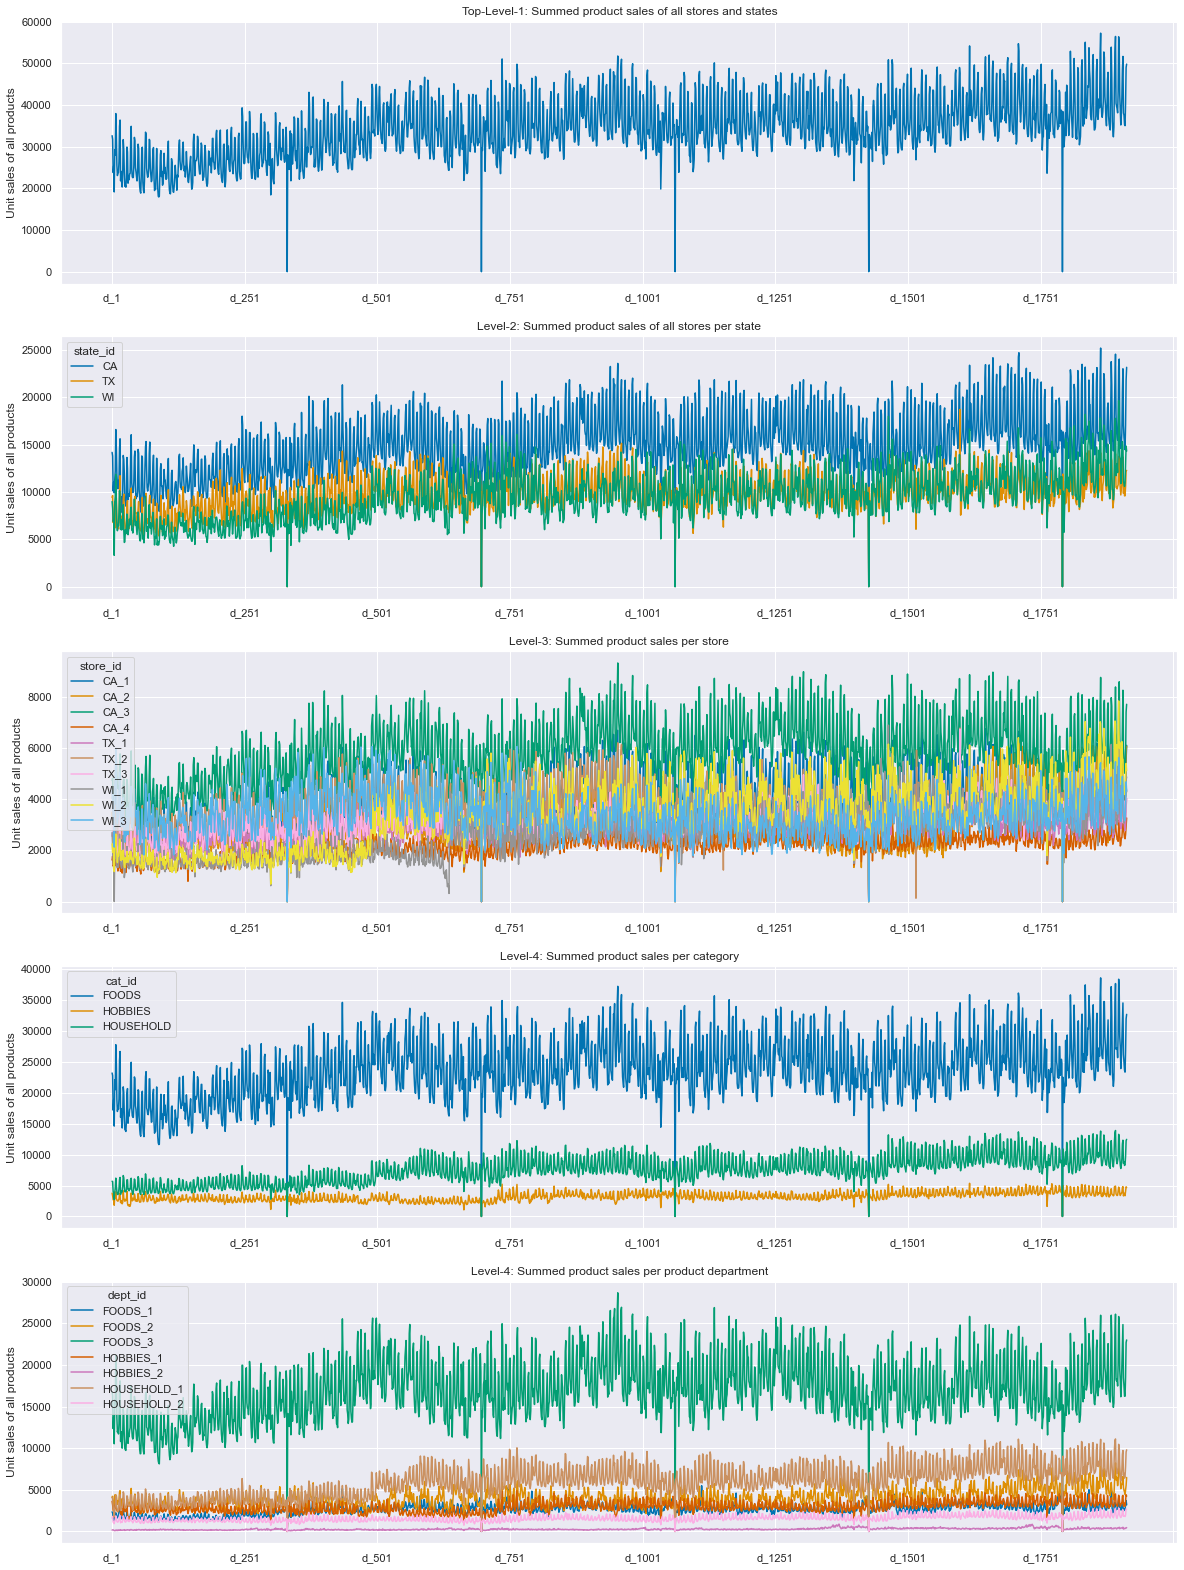

In [9]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

## Insights

It has become much clearer how these levels are aggregated by performing groupby- and summing up the sales.
We can already observe nice periodic patterns.

## How can we generate forecasts for grouped timeseries? 
Our training data consists of 30490 timeseries. They belong to the bottom-level 12: Unit sales of product x, aggregated for each store.

**A simple method to generate forecasts for all levels is to focus only on the bottom level.** All of its predictions are then summed up to create the forecasts of all levels up to the top. This is called the bottom-up approach.
As you can see here, there are many more approaches one could use, for example top-down or middle-out.

## The submission format 
Intro 

We have 28 F-columns as we are predicting daily sales for the next 28 days.

We are asked to make uncertainty estimates for these days

In [10]:
submission = pd.read_csv("/Users/Asus/Documents/Atmel Studio/sample_submission.csv")
submission.head(10)

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  F19  \
0  Total_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
1     CA_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
2     TX_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
3     WI_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
4   CA_1_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
5   CA_2_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
6   CA_3_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
7   CA_4_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
8   TX_1_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
9   TX_2_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   

   F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0  
5    0    0    0    0    0    0    0    0    0  
6    0    0    0    0    0    0    0    0    0  
7    0    0    0    0    0    0    0    0    0  
8    0    0    0    0    0    0    0    0    0  
9    0    0    0    0    0    0    0    0    0  

[10 rows x 29 columns]

In [11]:
submission.shape

(771120, 29)

In the first submission row we are asked to make precitions for the top level 1 (unit sales of all products, aggregated for all stores/states)
The next 3 rows represent level 2.
Followed by level 3.

This may goes on and on until the bottom level 12 is reached? Probably not as there seem to be only 3 combinations of ids.
Some rows contain aggregations at different levels. An X indicates the absence of an second aggregration level.

The prediction interval can be validation (related to the public leaderboard) or evaluation (related to the private leaderboard).

## Prediction intervals and quartiles ¶
Reading in the competition guideline, we can find that we are asked to make predictions for the median and four prediction intervals (PI): 50%, 67%, 95% and 99%. They belong to the following quartiles:

99% PI -  u1=0.005  and  u9=0.995 

95% PI -  u2=0.025  and  u8=0.975 

67% PI -  u3=0.165  and  u7=0.835 

50% PI -  u4=0.25  and  u6=0.75 

median -  u5=0.5

In [12]:
np.random.choice(submission.id.values, replace=False, size=15)

array(['HOBBIES_1_388_TX_1_0.250_validation',
       'HOUSEHOLD_2_231_TX_1_0.500_evaluation',
       'FOODS_2_394_WI_3_0.750_evaluation',
       'CA_HOBBIES_2_048_0.835_evaluation',
       'TX_FOODS_3_609_0.025_evaluation',
       'CA_HOBBIES_1_326_0.165_evaluation',
       'FOODS_3_671_CA_1_0.250_validation',
       'HOBBIES_1_322_WI_3_0.500_validation',
       'FOODS_3_423_CA_2_0.250_evaluation',
       'HOUSEHOLD_1_348_X_0.165_validation',
       'HOBBIES_1_277_CA_4_0.250_validation',
       'HOBBIES_1_262_TX_3_0.975_evaluation',
       'HOUSEHOLD_1_340_WI_1_0.025_evaluation',
       'HOBBIES_1_016_WI_2_0.025_validation',
       'HOUSEHOLD_2_214_CA_4_0.250_evaluation'], dtype=object)

### Browsing through the submission ids, we can see that we are given values of  ui  and information about the aggregation type like:

the state id

the department id

the item id

the store id

It's a bit confusing that missing states are not represented by X. This makes splitting the id for EDA a bit more complicated. :-( Furthermore there is no clear separator. The  _  sign is also present in the department id. It seems that one asked aggregation always consists of 3 ids. In cases of counts smaller than 3, we can observe X as placeholder.

In [13]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [14]:
submission_eda = pd.DataFrame(submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = submission.id.apply(lambda l: find_category(l))

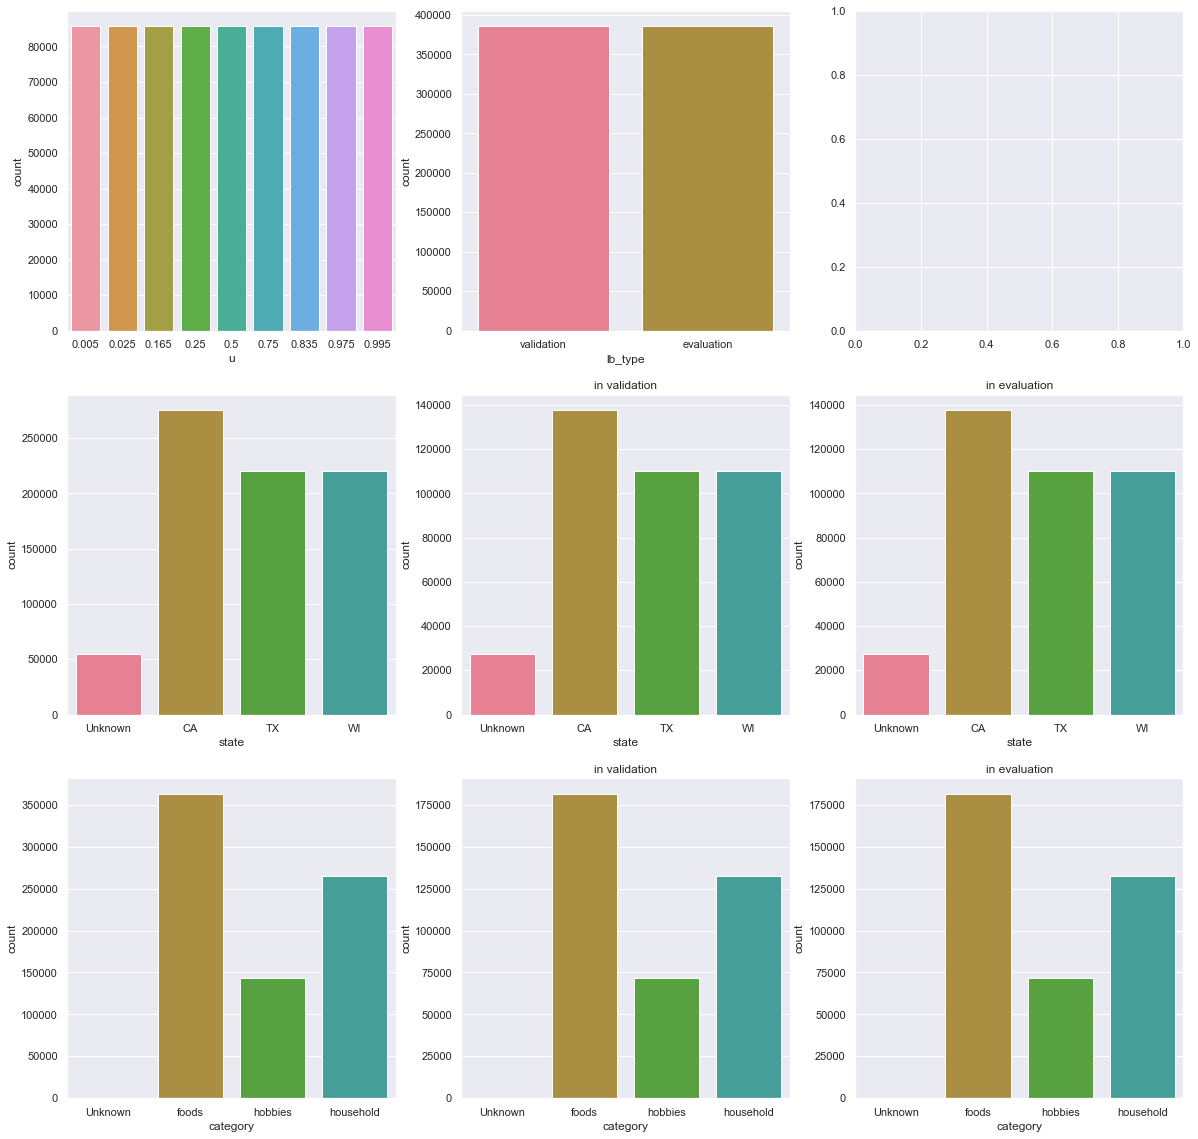

In [15]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(submission_eda.u, ax=ax[0,0]);
sns.countplot(submission_eda.lb_type, ax=ax[0,1]);
sns.countplot(submission_eda.state, ax=ax[1,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(submission_eda.category, ax=ax[2,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,2].set_title("in evaluation")
    ax[n,1].set_title("in validation")

## Insights
Each quartile u has exactily  2∗42840=85680  requests. 

The total number of all 12 level timeseries is 42840.
We have the same number of validation and evaluation requests and this explains the factor 2.
It seems that really all 12 aggregation levels are represented in the submission id. This is not clear yet and can be shown with further EDA (work in progress).

## The Weighted Scaled Pinball loss

### Playing with the loss implementation 
Let's pick a single timeseries to get started with the loss and its implementation. As I just like to get started it's a bit quick and dirty and surely not the best way to write it down. ;-)

In [16]:
def spl_denominator(train_series):
    N = len(train_series)
    sumup = 0
    for n in range(1, N):
        sumup += np.abs(train_series[n]-train_series[n-1])
    return sumup/(N-1)

In [17]:
def spl_numerator(dev_series, Q, u):
    sumup = 0
    for m in range(len(dev_series)):
        if Q[m] <= dev_series[m]:
            sumup += (dev_series[m] - Q[m])*u
        else:
            sumup += (Q[m] - dev_series[m])*(1-u)
    return sumup

In [18]:
def spl(train_series, dev_series, Q, u):
    h = len(dev_series)
    spl_denomina = spl_denominator(train_series)
    spl_numera = spl_numerator(dev_series, Q, u)
    
    return spl_numera/(h*spl_denomina)

## Computing the loss for one timeseries of level 12 

In [19]:
idx = 1000

In [20]:
train[level_cols].iloc[idx]

id          HOUSEHOLD_1_445_CA_1_validation
item_id                     HOUSEHOLD_1_445
dept_id                         HOUSEHOLD_1
cat_id                            HOUSEHOLD
store_id                               CA_1
state_id                                 CA
Name: 1000, dtype: object

In [21]:
train.loc[train.item_id=="HOUSEHOLD_1_445"].store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

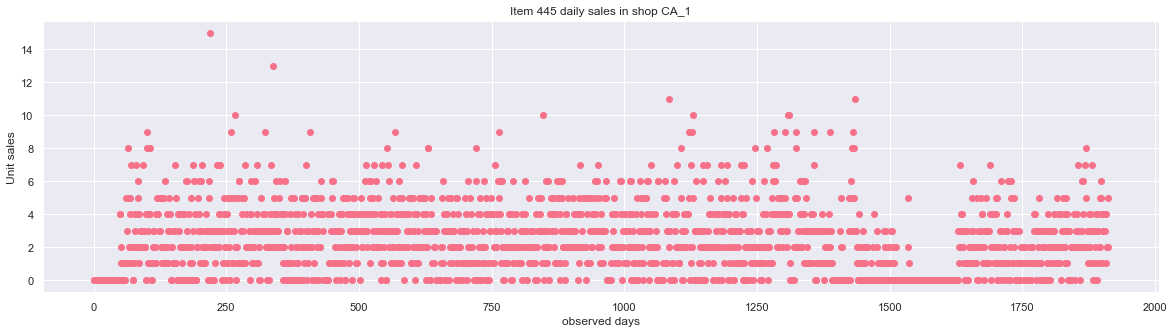

In [22]:
plt.figure(figsize=(20,5))
plt.plot(train[series_cols].iloc[idx].values, 'o')
plt.title("Item 445 daily sales in shop CA_1");
plt.xlabel("observed days")
plt.ylabel("Unit sales");

Now, we need to split our single row data into a training and validation (dev) part. I decided to use the same period of time (28 days) for validation:

In [23]:
timeseries = train[series_cols].iloc[idx].values
h = 28

train_timeseries = timeseries[0:len(timeseries)-h]
dev_timeseries = timeseries[(len(timeseries)-h)::]

print(len(train_timeseries), len(dev_timeseries))

1885 28


### Then we choose the last known value of the train timeseries as predictions for all asked 28 time points:

In [24]:
naive_val = train_timeseries[-1]
naive_Q = np.ones(dev_timeseries.shape) * naive_val
naive_Q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
spl(train_timeseries, dev_timeseries, naive_Q, 0.5)

0.8187879588064431

### Residual analysis¶
Ok, let's start with the computation of residuals for our example time series. As we assumed that the last known value is valid for all future values, I would choose this one also as fitted value for all training data points in the past:

In [26]:
residuals = train_timeseries - naive_val

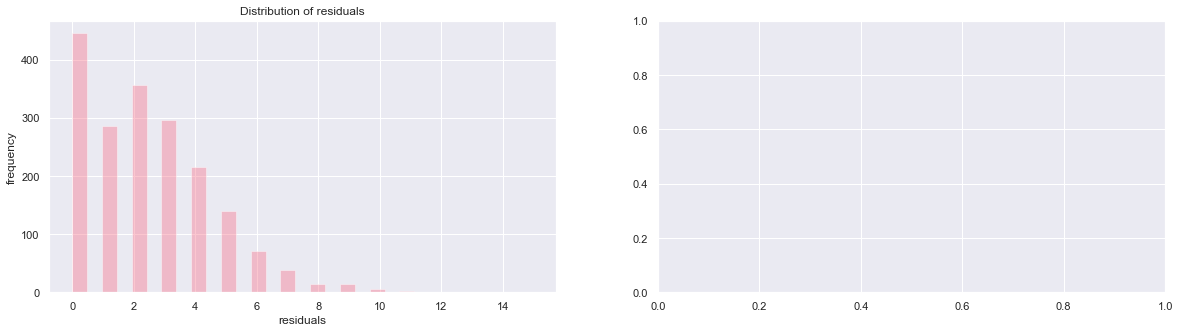

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(residuals, ax=ax[0], kde=False)
ax[0].set_xlabel("residuals")
ax[0].set_ylabel("frequency");
ax[0].set_title("Distribution of residuals");

In [28]:
np.mean(residuals)

2.3745358090185675

## Insights
As the last known value was 0 and this value is also the only possible minimum value, we do not observe a normal distribution of residuals!
Furthermore the mean of our residuals is not zero. In this case they are called biased and it's also an indicator that our model does not suite well.

I have decided to compute this example for the bottom level 12. In contrast to top-level time series the corresponding series do not show nice and clear periodic patterns that would likely yield more normally distributed residuals.

Consequently we may conclude that some methods and models could be better suited for top or low-level series in the hierarchy but not for both. This is something to keep in mind.

In [29]:
std_dev = np.std(residuals)
std_h = np.ones(dev_timeseries.shape)

for h in range(1, 29):
    std_h[h-1] = std_dev * np.sqrt(h)

In [30]:
std_h

array([ 2.09300689,  2.95995873,  3.62519427,  4.18601378,  4.68010568,
        5.1267989 ,  5.53757572,  5.91991746,  6.27902067,  6.61866893,
        6.94171853,  7.25038854,  7.54644366,  7.83131468,  8.10618082,
        8.37202755,  8.62968848,  8.87987618,  9.12320551,  9.36021136,
        9.5913625 ,  9.81707249, 10.03770841, 10.25359781, 10.46503444,
       10.67228297, 10.87558281, 11.07515144])

In [31]:
y_lower = np.ones(len(std_h))
y_upper = np.ones(len(std_h))
for h in range(len(std_h)):
    low_val = naive_Q[h] - 2.58 * std_h[h]
    if low_val < 0:
        y_lower[h] = 0
    else:
        y_lower[h] = low_val
    y_upper[h] = naive_Q[h] + 2.58 * std_h[h]

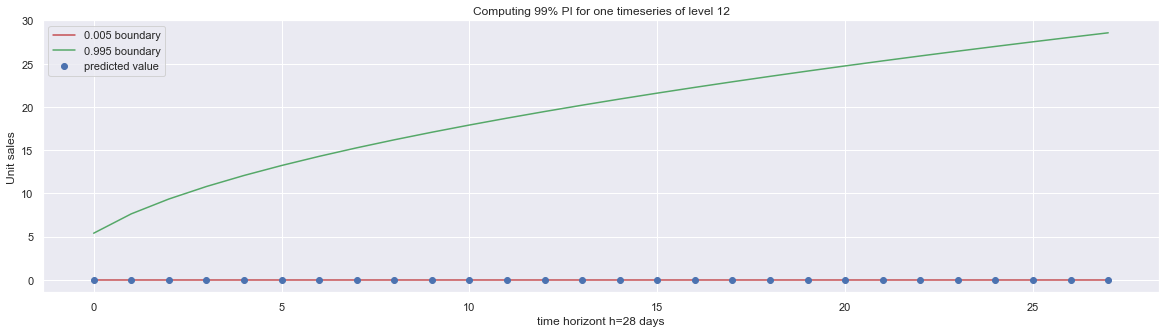

In [32]:
plt.figure(figsize=(20,5))
plt.plot(y_lower, c="r", label="0.005 boundary")
plt.plot(y_upper, c="g", label="0.995 boundary")
plt.plot(naive_Q, 'o', c="b", label="predicted value")
plt.title("Computing 99% PI for one timeseries of level 12");
plt.xlabel("time horizont h=28 days")
plt.ylabel("Unit sales");
plt.legend();

## Uncertainty estimates¶
By default it returns uncertainty intervals of the predicted value  yhat  consisting of three different sources:

uncertainty in the trend,

uncertainty in the seasonality estimates,

additional observation noise

To compute the uncertainty in the trend it is assumed that the average frequency and magnitude of trend changes will be the same in the future as observed in the history. This trend changes are projected forward into the future and by computing their distribution uncertainty intervals are obtained. By default **Prophet only returns uncertainty in the trend and observation noise!

In [33]:
timeseries = train[series_cols].sum().values
len(timeseries)

1913

In [34]:
train_timeseries = timeseries[0:-28]
eval_timeseries = timeseries[-28::]
print(len(train_timeseries), len(eval_timeseries))
days = np.arange(1, len(series_cols)+1)

1885 28


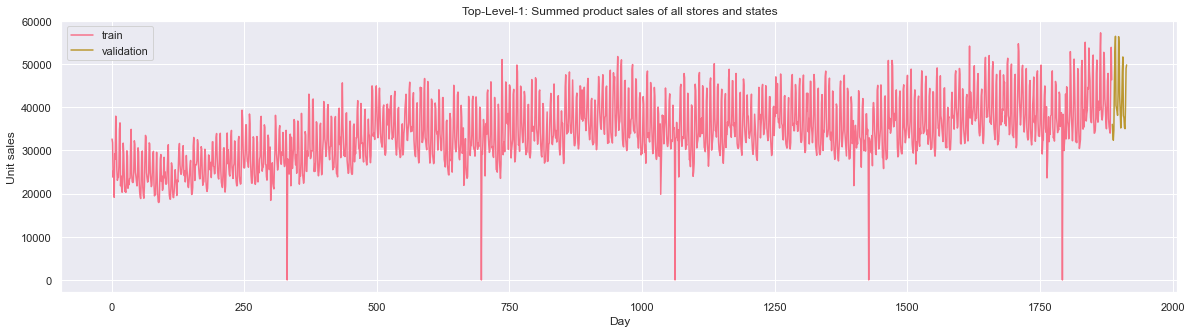

In [35]:
plt.figure(figsize=(20,5))
plt.plot(days[0:-28], train_timeseries, label="train")
plt.plot(days[-28::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [36]:
dates = calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(dates, columns=["ds"])
df.loc[:, "y"] = timeseries
df.head()

ds      y
0  2011-01-29  32631
1  2011-01-30  31749
2  2011-01-31  23783
3  2011-02-01  25412
4  2011-02-02  19146

In [37]:
uncertainty_interval_width = 0.25

In [38]:
train_df = df.iloc[0:-28]
train_df.shape

(1885, 2)

In [39]:
eval_df = df.iloc[-28::]
eval_df.shape

(28, 2)

In [40]:
m = Prophet(interval_width=uncertainty_interval_width)
m.fit(train_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2011-01-29  23513.894273  29416.165299  31620.216405  23513.894273   
1 2011-01-30  23527.405638  28960.696632  31109.819832  23527.405638   
2 2011-01-31  23540.917003  21241.765717  23472.302247  23540.917003   
3 2011-02-01  23554.428368  18443.643117  20761.903862  23554.428368   
4 2011-02-02  23567.939733  18352.970013  20638.376132  23567.939733   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  23513.894273     6954.730170           6954.730170           6954.730170   
1  23527.405638     6590.943020           6590.943020           6590.943020   
2  23540.917003    -1497.876409          -1497.876409          -1497.876409   
3  23554.428368    -3910.017992          -3910.017992          -3910.017992   
4  23567.939733    -4157.976903          -4157.976903          -4157.976903   

        weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  7191.769834   7191.769834   7191.769834 -237.039665   -237.039665   
1  6738.999124   6738.999124   6738.999124 -148.056104   -148.056104   
2 -1441.094639  -1441.094639  -1441.094639  -56.781771    -56.781771   
3 -3946.724161  -3946.724161  -3946.724161   36.706169     36.706169   
4 -4290.154584  -4290.154584  -4290.154584  132.177681    132.177681   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -237.039665                   0.0                         0.0   
1   -148.056104                   0.0                         0.0   
2    -56.781771                   0.0                         0.0   
3     36.706169                   0.0                         0.0   
4    132.177681                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  30468.624442  
1                         0.0  30118.348658  
2                         0.0  22043.040594  
3                         0.0  19644.410376  
4                         0.0  19409.962830

In [41]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

ds          yhat    yhat_lower    yhat_upper
0 2011-01-29  30468.624442  29416.165299  31620.216405
1 2011-01-30  30118.348658  28960.696632  31109.819832
2 2011-01-31  22043.040594  21241.765717  23472.302247
3 2011-02-01  19644.410376  18443.643117  20761.903862
4 2011-02-02  19409.962830  18352.970013  20638.376132

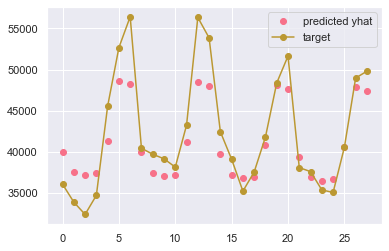

In [42]:
plt.plot(forecast.iloc[-28::].yhat.values, 'o', label="predicted yhat")
plt.plot(eval_df.y.values, 'o-', label="target")
plt.legend();

In [43]:
fig = plot_plotly(m, forecast)  
py.iplot(fig)

### Submission for validation
Remember that we are asked to predict the following intervals PI:

99% PI -  u1=0.005  and  u9=0.995

95% PI -  u2=0.025  and  u8=0.975 

67% PI -  u3=0.165  and  u7=0.835

50% PI -  u4=0.25  and  u6=0.75 

median -  u5=0.5 

**Now let's fit the whole training data and predict for the validation timeperiod of the submission file. We have to set the interval in advance and personally it feels a bit overcomplicated to do so for each requested interval. But as I still need to understand Prophet in its details I'm going the following way:***

In [44]:
uncertainty_interval_width = 0.25

In [45]:
f_cols = [col for col in submission.columns if "F" in col]

In [46]:
submission_val = submission[submission.id.str.contains("validation")].copy()

In [47]:
def plugin_total_predictions():
    
    for uncertainty_interval_width in [0.005, 0.025, 0.165, 0.25]:
        upper = 1-uncertainty_interval_width
        lower = uncertainty_interval_width
    
        m = Prophet(interval_width=uncertainty_interval_width)
        m.fit(df)
        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(lower))),f_cols
        ] = np.round(forecast.yhat_lower.values[-28::])
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(upper))),f_cols
        ] = np.round(forecast.yhat_upper.values[-28::])
    
    submission_val.loc[
        (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(0.5))),f_cols
    ] = forecast.yhat.values[-28::]
    
    return submission_val

In [48]:
submission_val = plugin_total_predictions()
submission_val.loc[submission_val.id.str.contains("Total")]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


id            F1            F2            F3  \
0       Total_X_0.005_validation  39461.680847  36926.937247  36519.877357   
42840   Total_X_0.025_validation  39461.680847  36926.937247  36519.877357   
85680   Total_X_0.165_validation  38651.000000  36240.000000  35566.000000   
128520  Total_X_0.250_validation  38436.000000  35694.000000  35523.000000   
171360  Total_X_0.500_validation  39461.680847  36926.937247  36519.877357   
214200  Total_X_0.750_validation  40558.000000  37997.000000  37926.000000   
257040  Total_X_0.835_validation  40198.000000  37674.000000  37146.000000   
299880  Total_X_0.975_validation  39640.000000  37040.000000  36889.000000   
342720  Total_X_0.995_validation  39355.000000  37008.000000  36757.000000   

                  F4            F5            F6            F7            F8  \
0       36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
42840   36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
85680   35974.000000  39575.000000  47174.000000  46493.000000  38403.000000   
128520  35494.000000  39577.000000  46815.000000  46398.000000  38460.000000   
171360  36668.818651  40645.949363  47965.928954  47509.392806  39219.150125   
214200  37882.000000  41854.000000  48986.000000  48613.000000  40379.000000   
257040  37625.000000  41012.000000  48679.000000  48077.000000  39920.000000   
299880  37083.000000  41016.000000  47875.000000  47704.000000  39125.000000   
342720  37095.000000  40595.000000  47956.000000  47293.000000  39238.000000   

                  F9  ...           F19          F20          F21  \
0       36699.986814  ...  40491.601394  47873.62449  47485.14468   
42840   36699.986814  ...  40491.601394  47873.62449  47485.14468   
85680   35970.000000  ...  39793.000000  47122.00000  46628.00000   
128520  35672.000000  ...  39406.000000  46929.00000  46332.00000   
171360  36699.986814  ...  40491.601394  47873.62449  47485.14468   
214200  37792.000000  ...  41556.000000  49165.00000  48788.00000   
257040  37507.000000  ...  41200.000000  48579.00000  48204.00000   
299880  36601.000000  ...  40670.000000  47996.00000  47591.00000   
342720  36705.000000  ...  40483.000000  47909.00000  47621.00000   

                 F22           F23           F24           F25           F26  \
0       39269.251834  36830.847436  36526.944931  36785.936744  40879.929854   
42840   39269.251834  36830.847436  36526.944931  36785.936744  40879.929854   
85680   38574.000000  36149.000000  35935.000000  36115.000000  39887.000000   
128520  37869.000000  35795.000000  35425.000000  35713.000000  39524.000000   
171360  39269.251834  36830.847436  36526.944931  36785.936744  40879.929854   
214200  40034.000000  38042.000000  37586.000000  37828.000000  41727.000000   
257040  40081.000000  37737.000000  37484.000000  37588.000000  41196.000000   
299880  39470.000000  36966.000000  36674.000000  36822.000000  40851.000000   
342720  39129.000000  36883.000000  36663.000000  36774.000000  40861.000000   

                 F27           F28  
0       48323.324292  47996.301448  
42840   48323.324292  47996.301448  
85680   47731.000000  47211.000000  
128520  47315.000000  46838.000000  
171360  48323.324292  47996.301448  
214200  49416.000000  48981.000000  
257040  49184.000000  48699.000000  
299880  48309.000000  48022.000000  
342720  48181.000000  48232.000000  

[9 rows x 29 columns]

Personally I feel a strong need for Bayesian ML oand credible intervals. What I miss most is a much more detailed mathematical description of Prophet in the documentation. Only using the model without a deeper understanding of what is going on feels very sloppy and dangerous. :-(

### LSTM and bootstrapped residuals

### Basic idea
Here we are using the Frequentist perspective of probability:

The model parameters  w  are assumed to be fixed and we estimate it using our estimator.

The estimation depends on the dataset D we observe and consequently we can obtain error bars for our estimated parameters  west  by considering multiple datasets.

One way to do this is by creating new datasets, for example with bootstrapping.

We are creating new datasets by using bootstrapped residuals:

We only assume uncorrelated residuals that need not be normally distributed.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Setting up LSTM

In [50]:
class MyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, batch_size, num_layers=1, output_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.num_layers,
                            dropout = 0.25)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
    def init_hidden(self):
        self.h_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        self.c_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
    
    def forward(self, x):
        lstm_output, (h_n, c_n) = self.lstm(x.view(len(x), self.batch_size, -1),
                                           (self.h_zero, self.c_zero))
        last_time_step = lstm_output.view(self.batch_size, len(x), self.hidden_dim)[-1]
        pred = self.linear(last_time_step)
        return pred
    

def train_model(model, data_dict, lr=1e-4, num_epochs=500):
    
    loss_fun = torch.nn.MSELoss(reduction="mean")
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = np.zeros(num_epochs)
    phases = ["train", "eval"]
    losses_dict = {"train": [], "eval": []}
    predictions_dict = {"train": [], "eval": [] }
    
    for n in range(num_epochs):
        
        for phase in phases:
            
            x = data_dict[phase]["input"].to(device, dtype=torch.float)
            y = data_dict[phase]["target"].to(device, dtype=torch.float)
            
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            optimiser.zero_grad()
            
            model.init_hidden()
            y_pred = model(x)
            
            if n == (num_epochs-1):
                predictions_dict[phase] = y_pred.float().cpu().detach().numpy()
            
            loss = loss_fun(y_pred.float(), y)
            losses_dict[phase].append(loss.item())
            
            if n % 50 == 0:
                print("{} loss: {}".format(phase, loss.item()))
            
            if phase == 'train':
                loss.backward()
                optimiser.step()
        
    return losses_dict, predictions_dict

def create_sequences(timeseries, seq_len):
    inputs = []
    targets = []
    
    max_steps = len(timeseries) - (seq_len+1)
    
    for t in range(max_steps):
        x = timeseries[t:(t+seq_len)]
        y = timeseries[t+seq_len]
        inputs.append(x)
        targets.append(y)
    
    return np.array(inputs), np.array(targets)

## The top timeseries - preprocessing 

Let's use the timeseries of total unit sales as an example again. For preprocessing we should remove the trend and scale the values.

In [51]:
diff_series = np.diff(timeseries)
train_size = np.int(0.7 * len(diff_series))
train_diff_series = diff_series[0:train_size]
eval_diff_series = diff_series[train_size::]
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_train = scaler.fit_transform(train_diff_series.reshape(-1, 1))
scaled_eval = scaler.transform(eval_diff_series.reshape(-1,1))

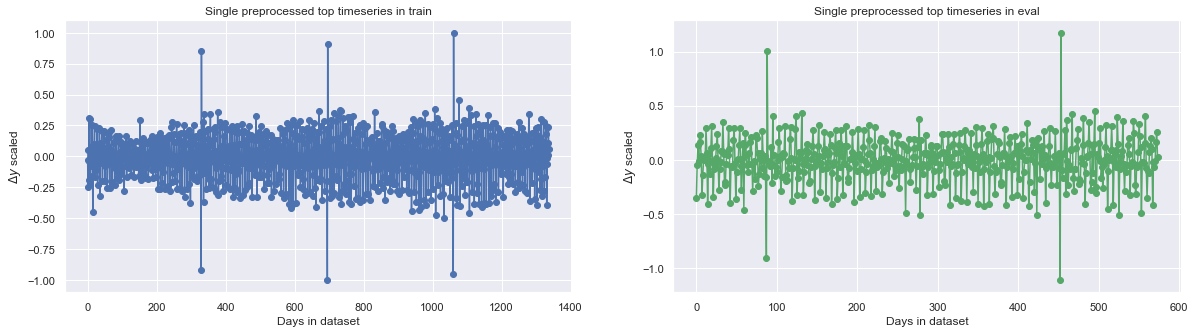

In [52]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(scaled_train, '-o', c="b")
ax[1].plot(scaled_eval, '-o', c="g")
ax[0].set_title("Single preprocessed top timeseries in train")
ax[1].set_title("Single preprocessed top timeseries in eval");
ax[0].set_xlabel("Days in dataset")
ax[1].set_xlabel("Days in dataset")
ax[0].set_ylabel("$\Delta y$ scaled")
ax[1].set_ylabel("$\Delta y$ scaled");

## Fitting the model to the top-level series 

In [53]:
seq_len = 400
input_dim = 1
hidden_dim = 128
num_epochs = 600
lr=0.0005


x_train, y_train = create_sequences(scaled_train, seq_len)
x_eval, y_eval = create_sequences(scaled_eval, seq_len)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_eval = torch.from_numpy(x_eval).float()
y_eval = torch.from_numpy(y_eval).float()

data_dict = {"train": {"input": x_train, "target": y_train},
             "eval": {"input": x_eval, "target": y_eval}}

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [55]:
model = MyLSTM(input_dim=input_dim,
               hidden_dim=hidden_dim,
               batch_size=seq_len)
model = model.to(device)

In [56]:
#GPU Runtime Error Occured
run_training = True
#if run_training:
#    losses_dict, predictions_dict = train_model(model, data_dict, num_epochs=num_epochs, lr=lr)

NameError: name 'losses_dict' is not defined

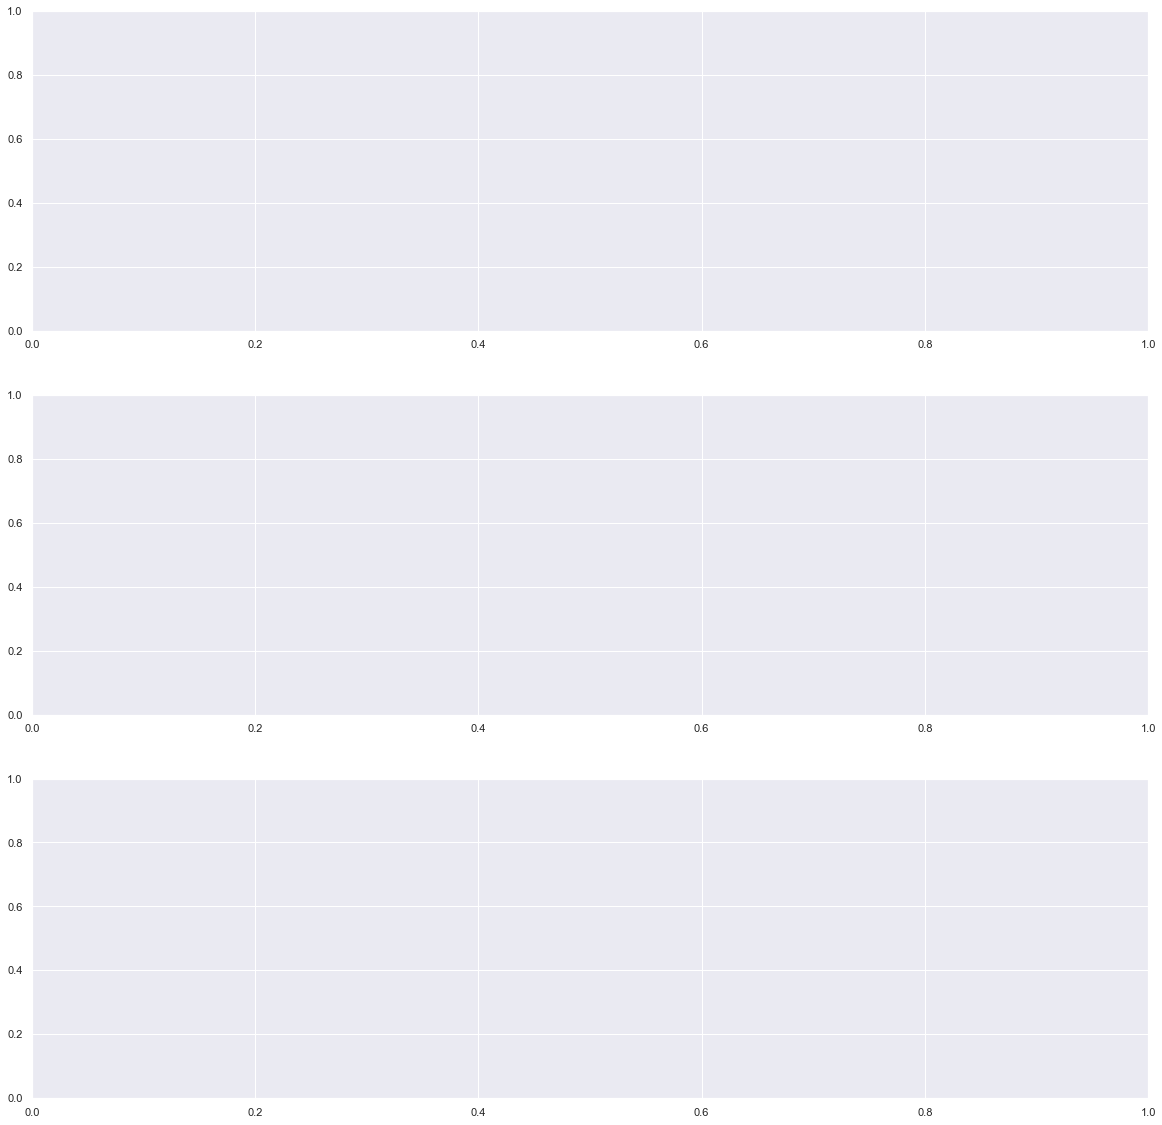

In [73]:
if run_training:
    
    fig, ax = plt.subplots(3,1,figsize=(20,20))
    ax[0].plot(losses_dict["train"], '.-', label="train", c="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    ax[0].plot(losses_dict["eval"], '.-', label="eval", c="blue");
    ax[0].legend();

    ax[1].plot(predictions_dict["train"], '-o', c="red")
    ax[1].plot(y_train, '-o', c="green")
    ax[1].set_title("Fitted and true values of y in train");
    ax[1].set_ylabel("Unit sales y");
    ax[1].set_xlabel("Number of days in train");

    ax[2].plot(predictions_dict["eval"], '-o', c="red")
    ax[2].plot(y_eval, '-o', c="green")
    ax[2].set_title("Predicted and true values of y in eval");
    ax[2].set_xlabel("Number of days in eval");
    ax[2].set_ylabel("Unit sales y");

In [68]:
from statsmodels.graphics.tsaplots import plot_acf

if run_training:
    
    train_residuals = y_train-predictions_dict["train"]
    eval_residuals = y_eval-predictions_dict["eval"]
    
    fig, ax = plt.subplots(2,2,figsize=(20,10))
    sns.distplot(train_residuals, ax=ax[0,0], color="red")
    sns.distplot(eval_residuals, ax=ax[0,1], color="green")
    ax[0,0].set_title("Train residuals")
    ax[0,1].set_title("Eval residuals")
    ax[0,0].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,1].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,0].set_ylabel("density")
    ax[0,1].set_ylabel("density")
    
    plot_acf(train_residuals, ax=ax[1,0])
    plot_acf(eval_residuals, ax=ax[1,1])

NameError: name 'predictions_dict' is not defined

## Computing PIs using bootstrapped residuals 

The idea of computing PIs using bootstrapped residuals is as follows:

Fit the model to your data to obtain the fitted values  y^i  and the forcasting errors  ϵi=ytrue,i−y^i .

Randomly sample a residual  ϵi  of the distribution of all  ϵj  to generate a new response variable  y∗  using the fitted value:  y∗=y^i+ϵi .

Doing this repeatively we obtain many different, synthetic values for future predictions that we can use to compute prediction intervals.

Let's take a look at a single example first:

In [69]:
sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_train), replace=True)
sampled_residuals = sampled_residuals.reshape(-1,1)
new_response = predictions_dict["train"] + sampled_residuals

NameError: name 'train_residuals' is not defined

NameError: name 'predictions_dict' is not defined

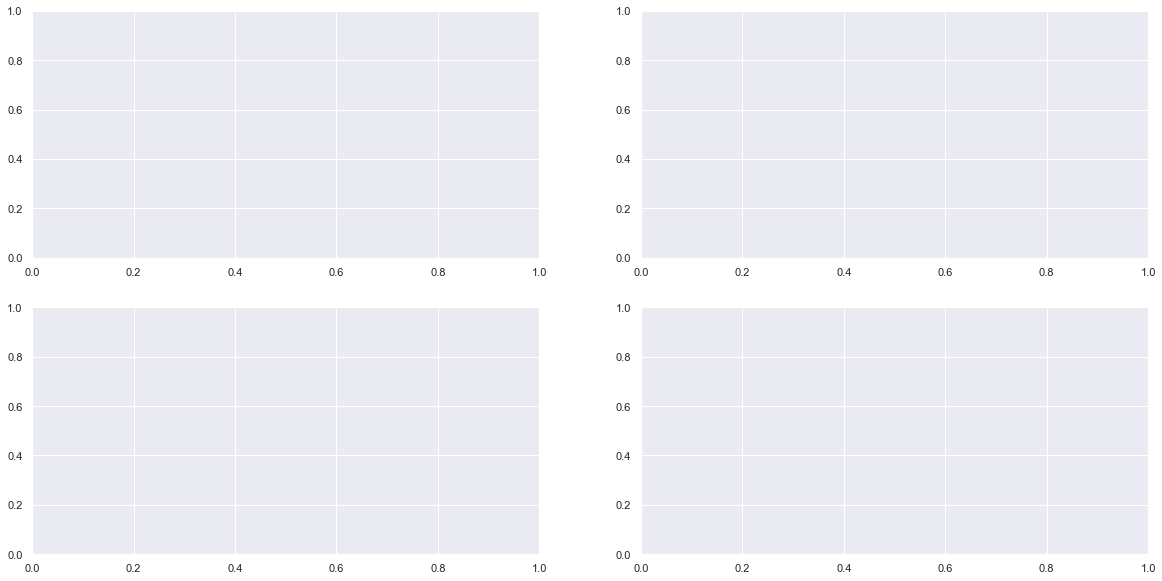

In [70]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(predictions_dict["train"][0:200], 'o-', color="purple")
ax[0,0].set_title("Original fitted values $y_{pred}$ in ")
ax[0,0].set_xlabel("200 example days")
ax[0,0].set_ylim(-0.4, 0.4)
ax[0,0].set_ylabel("$y_{fitted}$")

ax[0,1].plot(new_response[0:200,0], 'o-', color="orange")
ax[0,1].set_title("Response values $y^{*}$ using sampled residuals");
ax[0,1].set_xlabel("200 example days")
ax[0,1].set_ylabel("$y^{*}$");
ax[0,1].set_ylim(-0.4, 0.4)

ax[1,0].plot(sampled_residuals[0:200], 'o-', color="cornflowerblue")
ax[1,0].set_title("Sampled residuals")
ax[1,0].set_xlabel("200 example days")
ax[1,0].set_ylabel("$\epsilon$")

ax[1,1].plot(y_train[0:200], 'o-', color="firebrick")
ax[1,1].set_title("True values $y_{train}$")
ax[1,1].set_xlabel("200 example days")
ax[1,1].set_ylabel("$y_{train}$");


### We need to compute PIs for evaluation and validation data.

In my case, I have splitted the original training timeseries into my own eval and train part. Consequently instead of computing response series for the training data, we need to do this for the evaluation data. While doing so we also need to reverse the preprocessing:

In [74]:
responses = []
for n in range(100):
    # sample residuals using the historical residuals found in train
    sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_eval), replace=True)
    sampled_residuals = sampled_residuals.reshape(-1,1)
    # create a synthetic future timeseries of eval by adding sampled residuals
    new_response = predictions_dict["eval"] + sampled_residuals
    # reverse the scaling
    new_response = scaler.inverse_transform(new_response)
    # concat the first value of the evaluation series and the response series
    new_response = np.hstack((timeseries[train_size], new_response[:,0]))
    # reverse the differnciation (trend removal) using cumsum
    new_response = np.cumsum(new_response)
    # save the future timeseries
    responses.append(new_response)
    
responses = np.array(responses)
responses.shape

NameError: name 'train_residuals' is not defined

In [ ]:
y_eval.shape

In [ ]:
median_series = np.median(responses, axis=0)
eval_series = scaler.inverse_transform(y_eval)
eval_series = np.cumsum(np.hstack((timeseries[train_size-1], eval_series[:,0])))
low_q = 0.25
up_q = 0.75

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0, len(median_series)), median_series, 'o-', label="median predicted series")
plt.plot(eval_series, '.-', color="cornflowerblue", label="true eval series")
lower = np.quantile(responses, low_q, axis=0)
upper = np.quantile(responses, up_q, axis=0)
plt.fill_between(np.arange(0, len(median_series)), lower, upper, alpha=0.5)
plt.title("Prediction interval {}% of eval timeseries".format((up_q-low_q)*100));
plt.xlabel("Days in eval")
plt.ylabel("Unit sales");
plt.legend();